# Training a GAN

This notebook contains all of the code for training your own generative adversarial network. By default this notebooks is trained on images from the MNIST dataset (run `download-mnist-dataset.ipynb` first to download this yourself). Once you have trained it on MNIST you can try training it on another dataset of your choosing later on. 

This implementation is based on the DCGAN paper from 2015: https://arxiv.org/abs/1511.06434

DCGAN is a simple implementation that is easy to understand. However they require a lot of data (10,000+ images) and they only work well when the data is not too varied and images are aligned i some way. For training a higher fidelty GAN on a smaller dataset, see this notebook for fine-tuning styleGAN3: https://colab.research.google.com/github/dvschultz/stylegan3/blob/main/SG3.ipynb

Work your way through the code here. You can have a go at running this code and training your own model, however it is unlikely that you will be able to train your own model on a laptop CPU in the relatively short time we have in class.

Given the resource restrictions we have, there is a pre-trained model included in this weeks code `gan_weights_mnist_1000_epochs.pt` that you can use to do some tasks with generation in `gan-generation-tasks.ipynb` and `interactive-gan-generation.py`. Once you have worked through this notebook you can move onto those notebooks in your own time.

The code in this notebook is heavily modified from: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

First lets do some imports:

In [2]:
%matplotlib inline

import torch
import torchvision 

import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.utils as vutils
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import matplotlib.animation as animation

from IPython.display import HTML
from src.util import weights_init
from src.gan_model import Generator, Discriminator

#### Define hyperparameters

In [60]:
# Training and model hyper-parameters
device = 'cuda'
num_epochs = 20 # Number of epochs in training
batch_size = 32 # Number images in a training batch
image_size = 512 # Image resolution for training
num_channels = 3 # Number of channels in the iamge
z_dim = 100 # Size of latent dimension
n_f_maps = 32 # Number of convolutional feature maps in model
learning_rate = 0.0002 # Learning rate for optimiser
beta1 = 0.5 # Hyperparameter for ADAM optimiser

# Path to dataset
data_path = '../Week-5-GANs/Project/zipa______'
path_original = 'Project_AI/resized_grayscale_images'

# Set to true to start from existing trained weights
load_chk = False
save_path = 'gan_weights.pt'
load_path = 'gan_weights.pt'

In [26]:
dataset_original = torchvision.datasets.ImageFolder(root=path_original,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
dataloader_original = torch.utils.data.DataLoader(dataset_original, batch_size=batch_size,
                                         shuffle=True)
batch_original = next(iter(dataloader_original))

In [47]:
from PIL import Image

In [53]:
import os
path_original_images = 'C:/Users/23036361/Desktop/AI-4-Media-23-24/data/class-datasets/mnist/train_images'
first_im = os.listdir(path_original_images)[0]

In [54]:
first_im = Image.open("/".join([path_original_images, first_im]))

In [55]:
import numpy as np
np_img = np.asarray(first_im)

In [56]:
np_img.shape

(28, 28)

In [57]:
first_im

In [58]:
batch_original[0]

tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1.

In [59]:
dataset_original

Dataset ImageFolder
    Number of datapoints: 60000
    Root location: C:/Users/23036361/Desktop/AI-4-Media-23-24/data/class-datasets/mnist
    StandardTransform
Transform: Compose(
               Resize(size=128, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(128, 128))
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [ ]:
#normailizar con opencv resize
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep) [-2]
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (128, 128))

#### Load dataset

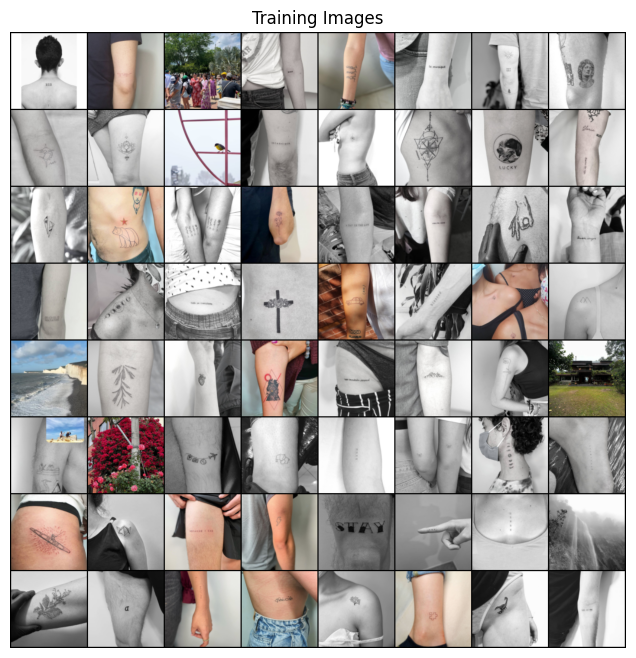

In [9]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = torchvision.datasets.ImageFolder(root=data_path,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
    
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True)

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

#### Setup core objects

Navigate to `src/gan_model.py` and spend some time reading the code there to see how the Generator and Discriminator are implemented. 

In [10]:
discriminator = Discriminator(n_f_maps,num_channels).to(device)
generator = Generator(z_dim,n_f_maps,num_channels).to(device)

if load_chk == True:
    checkpoint_sd = torch.load(load_path, map_location=torch.device('cpu'))
    generator.load_state_dict(checkpoint_sd['generator'])
    discriminator.load_state_dict(checkpoint_sd['discriminator'])
else:
    # Initial wieghts with values in specific range - see src/util.py for the implementation
    discriminator.apply(weights_init)
    generator.apply(weights_init)

# Our loss function is the Binary Cross Entropy loss
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, z_dim, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizerG = optim.Adam(generator.parameters(), lr=learning_rate, betas=(beta1, 0.999))

#### Training loop

In [11]:
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

# For each epoch
for epoch in range(num_epochs):
    
    # Cycle through batches of the dataset 
    for i, data_batch in enumerate(dataloader, 0):
        
        # Our dataset loader will give us the image batch and the associated class label 
        # We can ignore the class labels as we are treating the images in all folders as one big dataset
        image_data, class_label = data_batch
        image_data = image_data.to(device)
        # -----------------------------------------------------------
        # Phase 1: Update Discriminator network
        # Here we do two passes before updating the weights
        
        # Clear gradients of discriminator
        discriminator.zero_grad()

        # Train with a batch of real images
        
        minibatch_size = image_data.size(0)
        label = torch.full((minibatch_size,), real_label, dtype=torch.float, device=device)
        pred_D = discriminator(image_data).squeeze()
        errD_real = criterion(pred_D, label)
        errD_real.backward()
        D_x = pred_D.mean().item()

        ## Train with a batch of fake images
        noise = torch.randn(minibatch_size, z_dim, 1, 1, device=device)
        fake = generator(noise)
        label.fill_(fake_label)
        pred_D = discriminator(fake.detach()).squeeze()
        errD_fake = criterion(pred_D, label)
        errD_fake.backward()
        D_G_z1 = pred_D.mean().item()
        errD = errD_real + errD_fake
        
        # Update the weights of the discriminator network only
        optimizerD.step()

        # -----------------------------------------------------------
        # Phase 2: Update Generator network
        # Here we do two passes before updating the weights

        # Clear gradients of discriminator
        generator.zero_grad()

        # Take fake images and pass trh
        noise = torch.randn(minibatch_size, z_dim, 1, 1, device=device)
        fake = generator(noise)
        label.fill_(real_label)  # fake labels are real for generator cost
        pred_D = discriminator(fake).squeeze()
        errG = criterion(pred_D, label)
        errG.backward()
        D_G_z2 = pred_D.mean().item()
        
        # Update generator weights only
        optimizerG.step()

        # -----------------------------------------------------------
        # Now lets track our progress
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x) mean: %.4f\tD(G(z)) mean: %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = generator(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
            # Save model weights
            models_dict = {}
            models_dict['generator'] = generator.state_dict()
            models_dict['discriminator'] = discriminator.state_dict()
            torch.save(models_dict, save_path)
            
        iters += 1

ValueError: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 13, 13])) is deprecated. Please ensure they have the same size.

#### Plot lossses over training

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

#### interactive visualisation of training

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

#### Compare generated and real images

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

#### Tasks

**Task 1:** Run this notebook to see how GAN training operates. You probably only want to do a small number of epochs (between 3 and 10) to see how this goes. While this is training, move on to **Task 2**. Once you are done you can always interrupt [the training loop cell](#training-loop) and run the cells after to plot the performance of your model.

**Task 2:** Look at the implementation code for the **Generator** and **Discriminator** models in`src/gan_model.py` can you write some comments here to describe the differences between the models and their layer types?

**Task 3:** Move on to `gan-generation-tasks.ipynb` and do the tasks described there. You can either use your own trained model or the pre-trained model (`gan_weights_mnist_1000_epochs.pt) included in this weeks code notebook. 

**Task 4:** Move on to running the `interactive-gan-generation.py` script. Can you extend it to change the interaction that controls training? Such as using YOLO to create a controller to interact with the latent space or [use audio features](https://github.com/Louismac/dorothy/blob/main/examples/fft.py) to manipulate the latent variables before generation?

**Bonus task:** Following the material from the lecture, [take a look at this notebook for training an autoencoder and a variational autoencoder](https://avandekleut.github.io/vae/), what are the differences to this notebook when it comes to the implementation of the training? Download the notebook and run it for yourself. 